In [15]:
# loading the Python libraries we'll be using
from __future__ import print_function
import librosa
import numpy as np
#import umap
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# defining where things are
filepath = "./trackx.wav"
trimlensecs = 10   # num secs we like to view

In [16]:
# loading the file may take a few seconds if it's long
y, sr = librosa.load(filepath)
trimlensamples = librosa.core.time_to_samples(trimlensecs,sr=sr)

In [17]:
# let's pre-calculatea some features
spec = librosa.feature.melspectrogram(y=y, hop_length=512)
trimlenframes = librosa.core.time_to_frames(trimlensecs, hop_length=512)
mfcc = librosa.feature.mfcc(y=y)

In [18]:
# this function just defines our preferred way of plotting a spectrogram as an image
def plot_a_spectrogram(data_to_plot):
    data_to_plot = librosa.power_to_db(data_to_plot,ref=np.max)
    plt.imshow(data_to_plot, origin='lower', aspect='auto', interpolation='nearest')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()

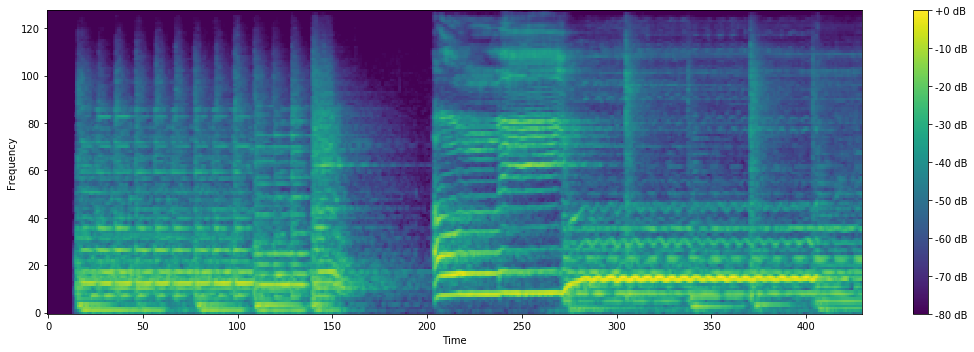

In [19]:
plt.figure(figsize=(15, 5))
plot_a_spectrogram(spec[:, :trimlenframes])

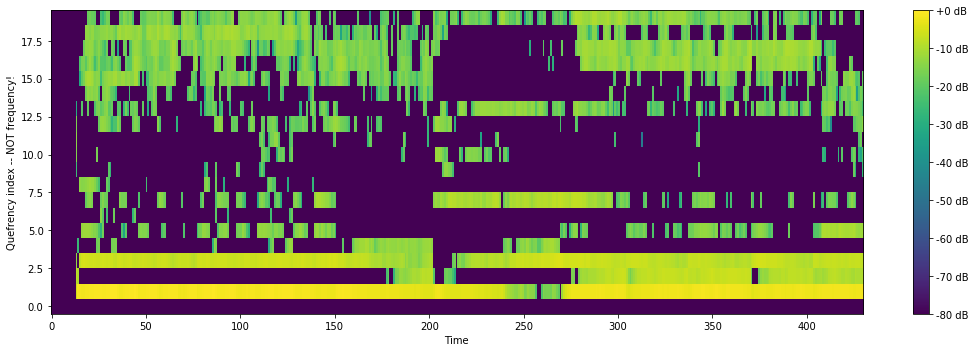

In [20]:
plt.figure(figsize=(15, 5))
plot_a_spectrogram(mfcc[:, :trimlenframes])
_ = plt.ylabel("Quefrency index -- NOT frequency!")

In [21]:
#embedding = umap.UMAP(n_neighbors=15, min_dist=0.01, metric='correlation').fit_transform(mfcc[:,::10].T)
embedding = sklearn.manifold.TSNE().fit_transform(mfcc.T)

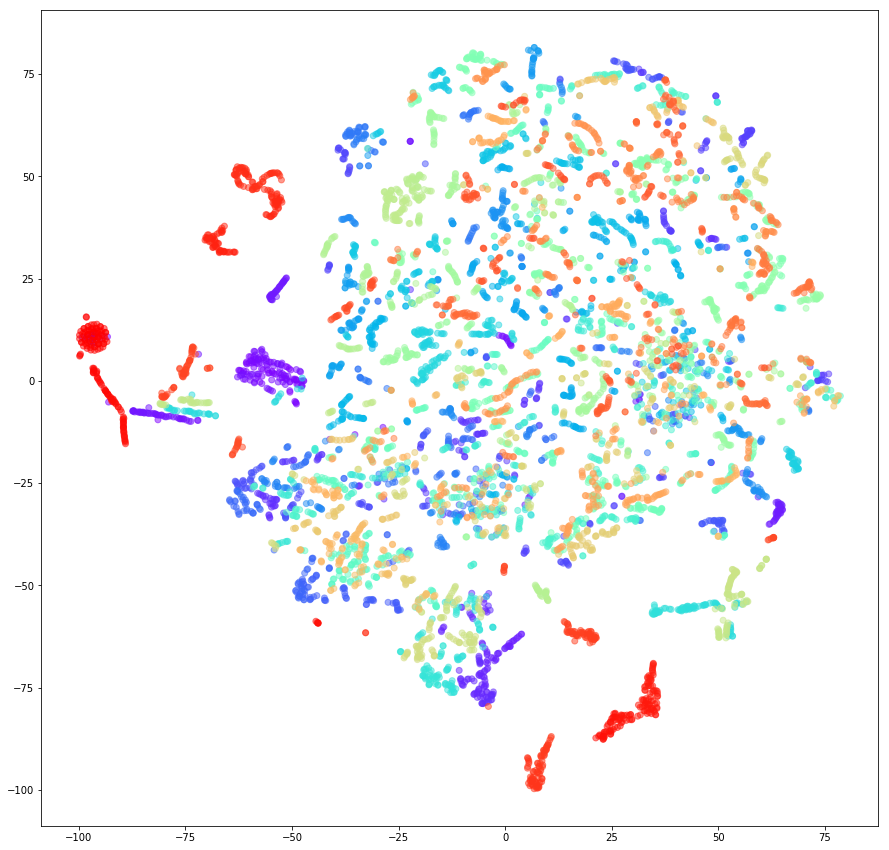

In [24]:
plt.figure(figsize=(15, 15))
#plt.scatter(embedding[:,0], embedding[:,1], alpha=0.5)

### with colour
cmap = plt.get_cmap('rainbow')
plt.scatter(embedding[:,0], embedding[:,1], c=np.arange(len(embedding)), cmap=cmap, alpha=0.5)

### timeseries plot
#plt.plot(np.arange(len(embedding)), embedding[:,0], alpha=0.5)
#plt.plot(np.arange(len(embedding)), embedding[:,1], alpha=0.5)
#plt.xlim(0, trimlenframes)


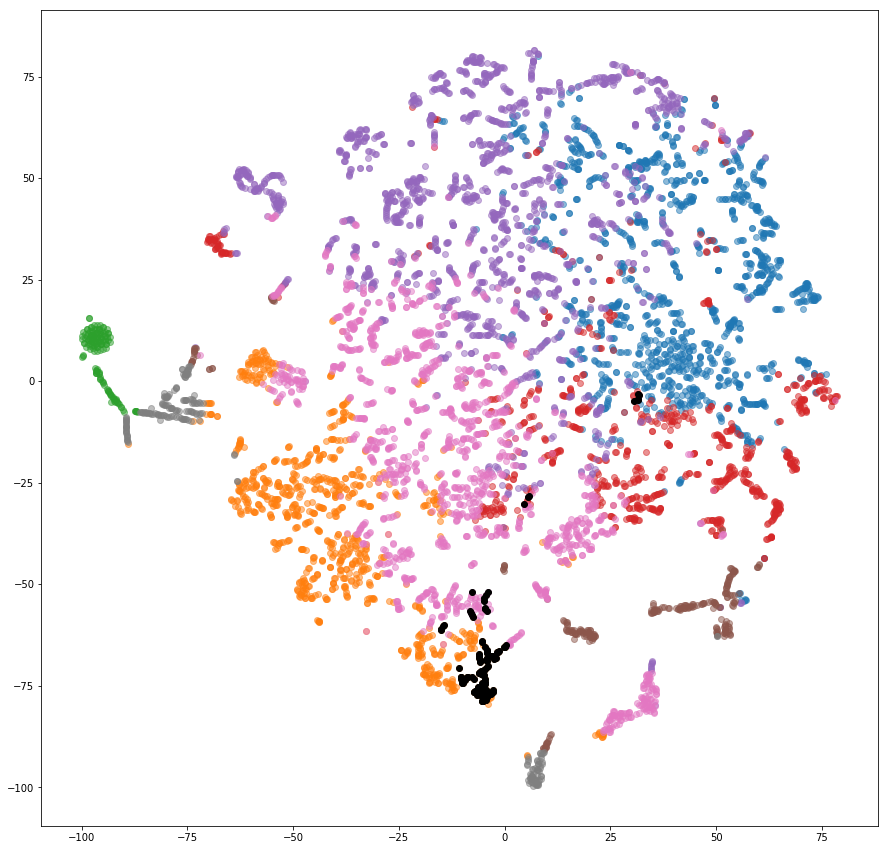

In [28]:
n_clusters=8
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(mfcc.T)
labels = kmeans.labels_
plt.figure(figsize=(15, 15))
for whichclust in range(n_clusters):
    plt.scatter(embedding[labels==whichclust,0], embedding[labels==whichclust,1], alpha=0.5)

#plt.scatter(embedding[210:270, 0], embedding[210:270, 1], color='k')
plt.scatter(embedding[290:400, 0], embedding[290:400, 1], color='k')

In [29]:
onsets = librosa.onset.onset_detect(y, sr)
detectionfunction = librosa.onset.onset_strength(y, sr)
onsets

array([  16,   28,   37,   48,   58,   68,   79,   90,  100,  110,  121,
        130,  141,  205,  240,  273,  306,  339,  372,  405,  437,  459,
        471,  486,  504,  516,  524,  570,  578,  627,  635,  668,  699,
        731,  764,  829,  861,  893,  925,  948,  957,  979,  992, 1021,
       1034, 1052, 1086, 1109, 1150, 1182, 1214, 1235, 1245, 1278, 1310,
       1344, 1362, 1374, 1407, 1432, 1471, 1503, 1525, 1535, 1547, 1556,
       1566, 1599, 1632, 1647, 1664, 1689, 1728, 1760, 1791, 1803, 1816,
       1824, 1857, 1920, 1933, 1952, 1982, 2046, 2111, 2144, 2163, 2184,
       2203, 2249, 2266, 2364, 2396, 2428, 2461, 2492, 2503, 2516, 2557,
       2569, 2576, 2591, 2622, 2633, 2641, 2654, 2686, 2718, 2750, 2771,
       2783, 2815, 2834, 2847, 2878, 2899, 2909, 2941, 2973, 3005, 3037,
       3069, 3090, 3101, 3119, 3133, 3164, 3195, 3227, 3259, 3291, 3323,
       3355, 3388, 3399, 3421, 3447, 3452, 3464, 3479, 3516, 3533, 3540,
       3580, 3611, 3644, 3675, 3706, 3718, 3740, 37

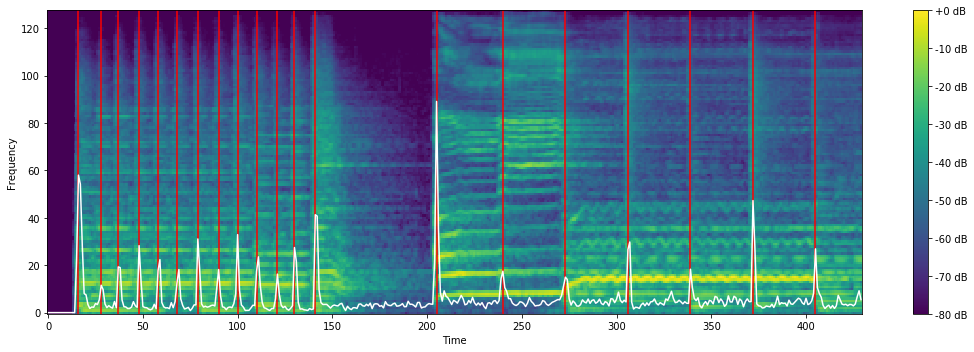

In [30]:
plt.figure(figsize=(15, 5))
plot_a_spectrogram(spec[:, :trimlenframes])
for anonset in onsets[onsets < trimlenframes]:
    plt.axvline(anonset, color='red')

plt.plot(detectionfunction[:trimlenframes] * 5, color='white')

In [ ]:
# let's try noise reduction by medianning etc
stat = np.percentile(spec, 50, axis=1, keepdims=True)
spec2 = np.maximum(0, spec - stat) # subtract the "stationary background" but ensure still nonnegative

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plot_a_spectrogram(spec[:, :trimlenframes])
plt.subplot(2, 1, 2)
plot_a_spectrogram(spec2[:, :trimlenframes])


In [ ]:

######################################################
# EXTRA arbitrary below here
######################################################


# this block is mainly about creating a figure with gaps between spectral frames

chosenchunkframes = range(265, 280) # range we'll zoom in on
chosenchunksamples = librosa.core.frames_to_samples(chosenchunkframes)


plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
for whichpos, posA in enumerate(chosenchunksamples):
    posB = posA + librosa.core.frames_to_samples(1)
    data_to_plot = y[posA:posB]
    plt.plot(range(posA+posA-chosenchunksamples[0], posB+posA-chosenchunksamples[0]), data_to_plot, color='k', linestyle='-')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(3, 1, 2)
data_to_plot = librosa.power_to_db(spec[:, chosenchunkframes],ref=np.max)
stretched = np.ones((data_to_plot.shape[0], data_to_plot.shape[1] * 2)) * -np.inf
stretched[:, ::2] = data_to_plot
plt.imshow(stretched, origin='lower', aspect='auto', interpolation='nearest')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(3, 1, 3)
data_to_plot = librosa.power_to_db(mfcc[:, chosenchunkframes],ref=np.max)
stretched = np.ones((data_to_plot.shape[0], data_to_plot.shape[1] * 2)) * -np.inf
stretched[:, ::2] = data_to_plot
plt.imshow(stretched, origin='lower', aspect='auto', interpolation='nearest')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()


In [ ]:
# this block is mainly about creating a figure with gaps between spectral frames

chosenchunkframes = range(265, 280) # range we'll zoom in on
chosenchunksamples = librosa.core.frames_to_samples(chosenchunkframes)

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(y[chosenchunksamples[0]:chosenchunksamples[-1]], color='k', linestyle='-')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(3, 1, 2)
data_to_plot = librosa.power_to_db(spec[:, chosenchunkframes],ref=np.max)
plt.imshow(data_to_plot, origin='lower', aspect='auto', interpolation='nearest')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(3, 1, 3)
data_to_plot = librosa.power_to_db(mfcc[:, chosenchunkframes],ref=np.max)
plt.imshow(data_to_plot, origin='lower', aspect='auto', interpolation='nearest')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
